In [113]:
import numpy as np
import torch
from torchvision.datasets import SVHN
import torchvision
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.optim as optim


import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
%matplotlib inline
#%config InlineBackend.figure_formats = ['pdf', 'svg']
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
from tqdm.notebook import tqdm
from functools import partial

import math

In [2]:
batch_size = 64
n_epochs = 50

Исследуется зависимость качества от выбора архитектуры

##Данные

In [3]:
from torchvision.transforms import Compose, ToTensor, Resize

In [4]:
svhn_data = SVHN(root='data/', download=True, transform=Compose([ToTensor(), Resize(size=(224, 224))]))

In [5]:
test_size = 12000
train_size = len(svhn_data) - test_size

train_ds, test_ds = random_split(svhn_data, [train_size, test_size])
len(train_ds), len(test_ds)

(61257, 12000)

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [7]:
svhn_data32 = SVHN(root='data32/', download=True, transform=Compose([ToTensor()]))

In [8]:
train_ds32, test_ds32 = random_split(svhn_data32, [train_size, test_size])
len(train_ds32), len(test_ds32)

(61257, 12000)

In [9]:
train_loader32 = DataLoader(train_ds32, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader32 = DataLoader(test_ds32, batch_size, num_workers=2, pin_memory=True)

##LeNet

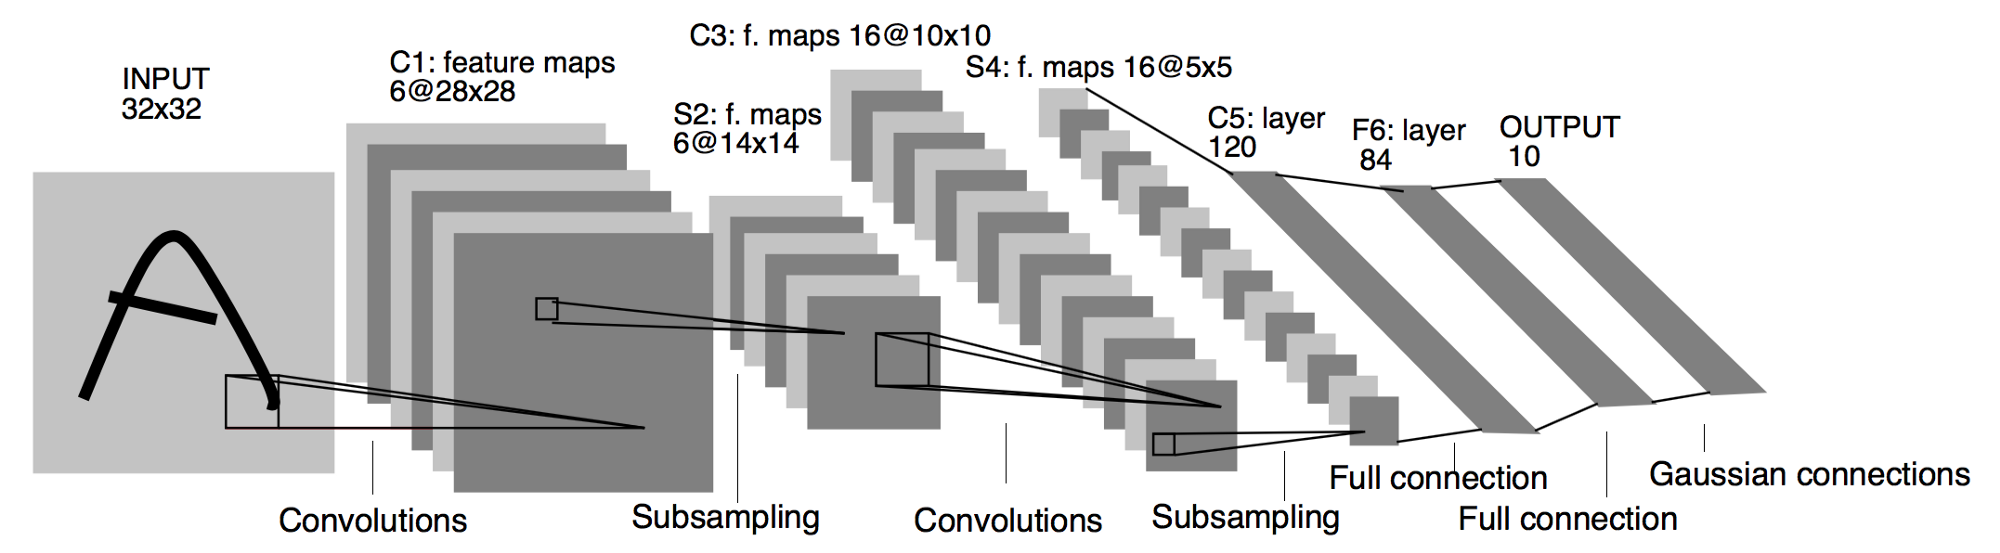

In [10]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
#         print(x.size())
        x = torch.flatten(x, 1)
#         print(x.size())
        logits = self.classifier(x)
        probs = nn.functional.softmax(logits, dim=1)
        return logits, probs

##AlexNet

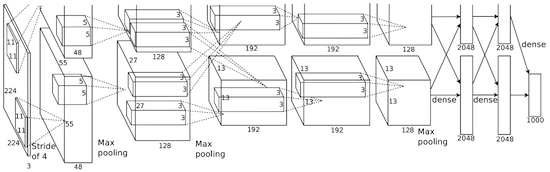

Сеть более глубокая, по сравнению с LeNet5. Нелинейности в виде Tanh заменены на ReLU

In [11]:
from torch.nn.modules.activation import ReLU
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super(AlexNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features= 9216, out_features= 4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features= 4096, out_features= 4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096 , out_features=n_classes),
        )

    def forward(self,x):
        x = self.feature_extractor(x)
        # x = x.reshape(x.shape[0], -1)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = nn.functional.softmax(logits, dim=1)
        return logits, probs

##VGG 13

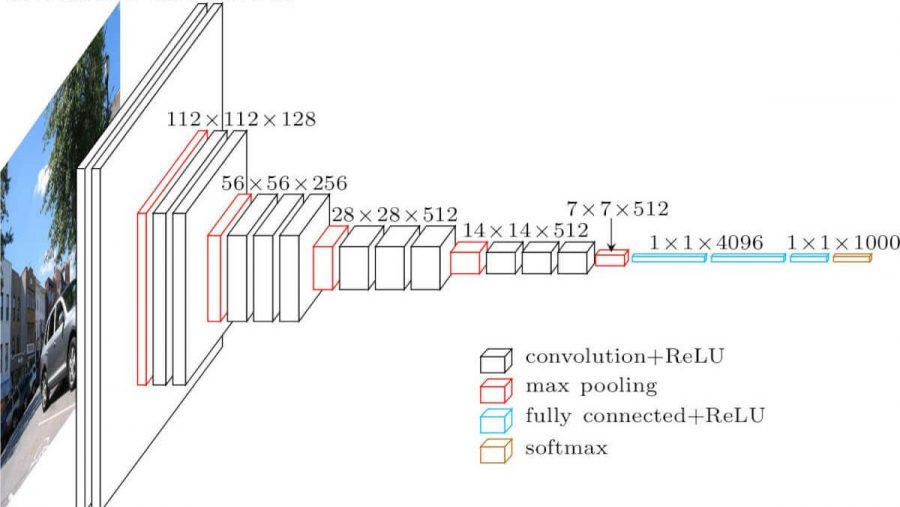

Особенность сети - вместо больших сверток используются последовательности сверток с меньшим ядром.

In [12]:
class VGG(nn.Module):

    def __init__(self, features, n_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, n_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probas = nn.functional.softmax(logits, dim=1)
        return logits, probas

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [13]:
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

##ResNet

Source: https://chsasank.com/vision/_modules/torchvision/models/resnet.html

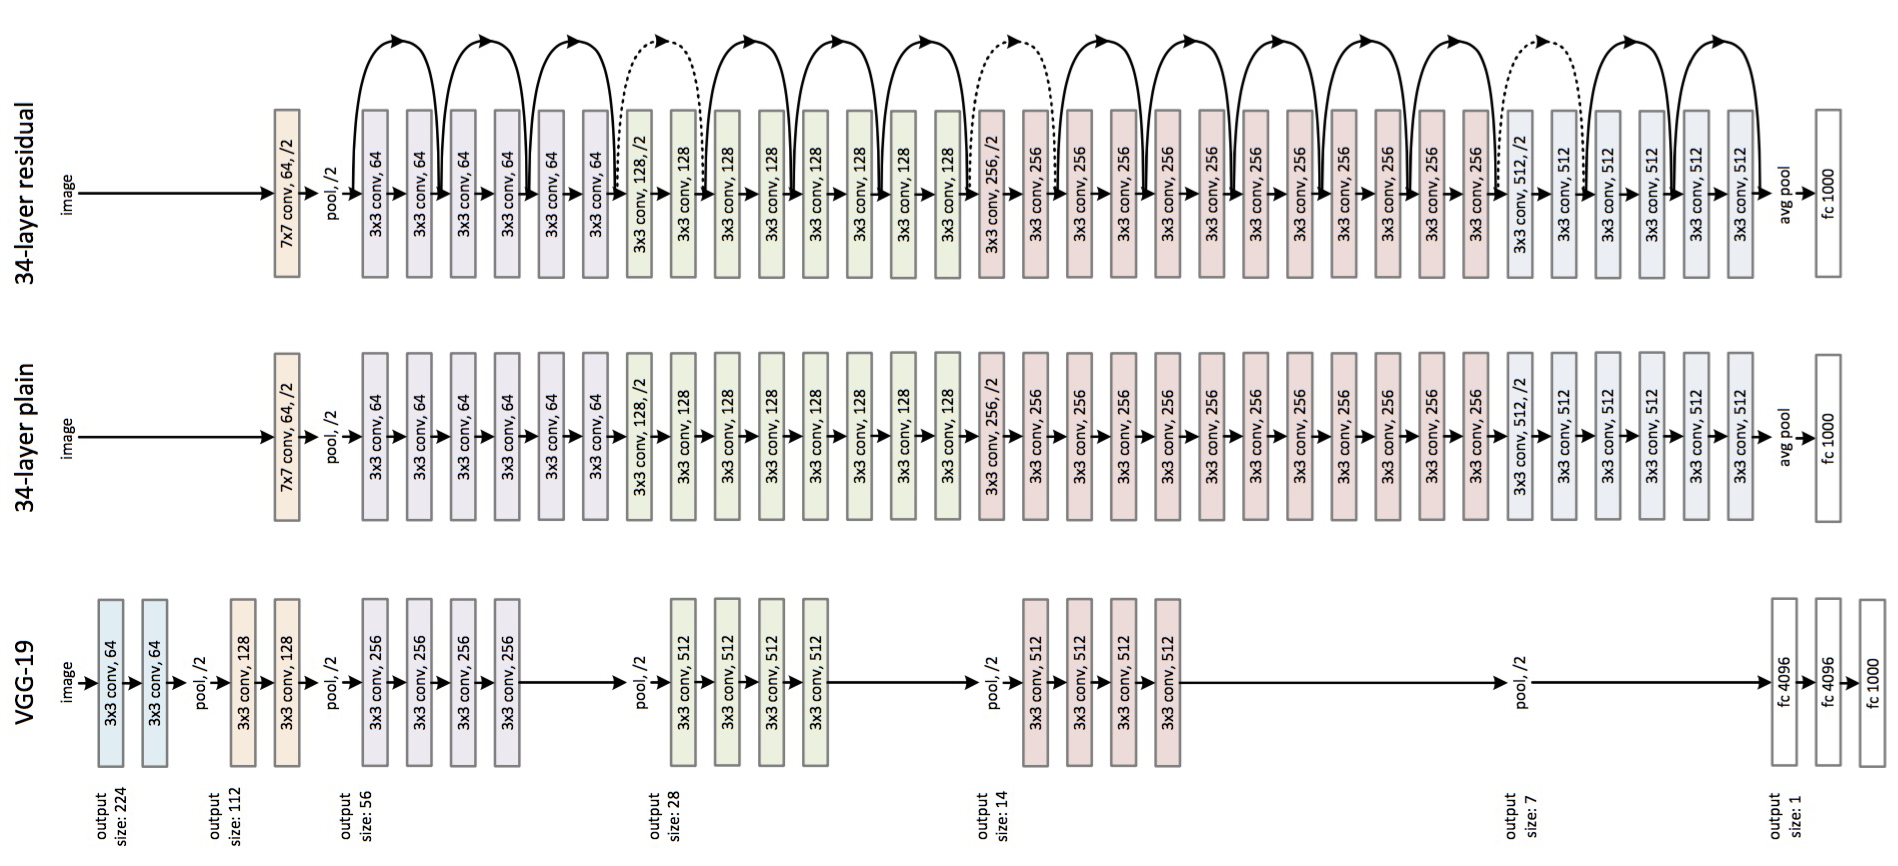

Особенность сети - к выходам слоев прибавляем входы. Делается это для борьбы с затухающим градиентом.

In [56]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, n_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        
        probas = nn.functional.softmax(logits, dim=1)

        return logits, probas

In [57]:
def resnet18(**kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

##Inception

Source: https://github.com/antspy/inception_v1.pytorch/blob/master/inception_v1.py

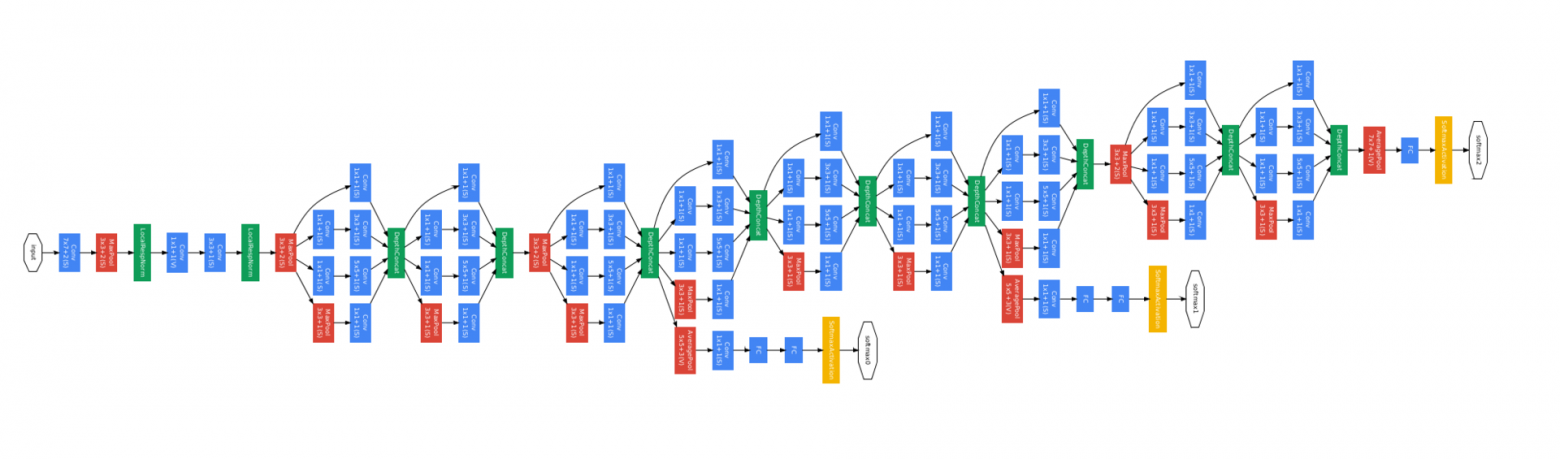

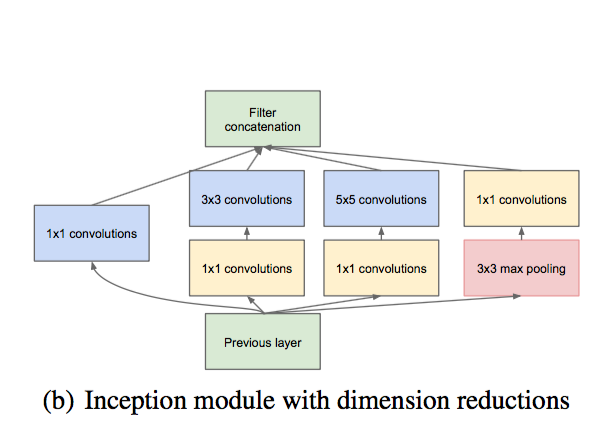

In [77]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self, n_classes=10):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, n_classes)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        probas = nn.functional.softmax(out, dim=1)
        return out, probas

##DenseNet

Source: https://github.com/bamos/densenet.pytorch

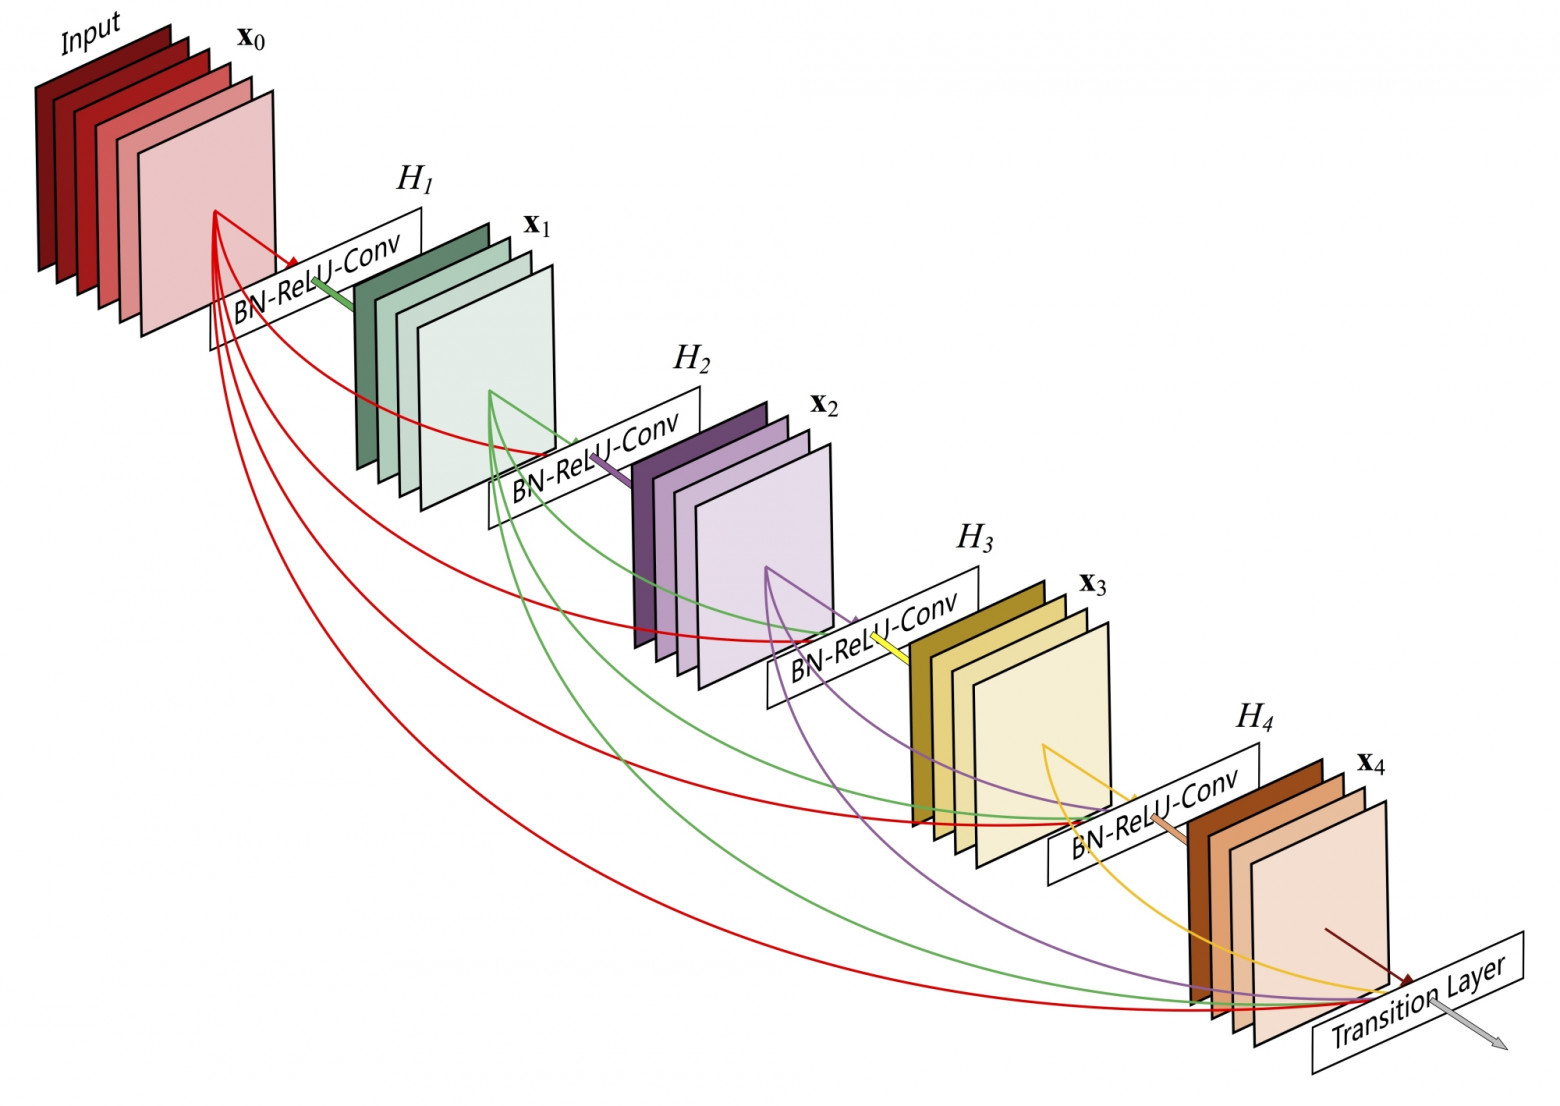

Здесь каждый слой соединен с каждым предыдущим

In [106]:
class Bottleneck(nn.Module):
    def __init__(self, n_channels, growth_rate):
        super(Bottleneck, self).__init__()
        inter_channels = 4 * growth_rate
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv1 = nn.Conv2d(n_channels, inter_channels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, growth_rate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(nn.functional.relu(self.bn1(x)))
        out = self.conv2(nn.functional.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

class SingleLayer(nn.Module):
    def __init__(self, n_channels, growth_rate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv1 = nn.Conv2d(n_channels, growth_rate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(nn.functional.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, n_channels, n_out_channels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv1 = nn.Conv2d(n_channels, n_out_channels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(nn.functional.relu(self.bn1(x)))
        out = nn.functional.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growth_rate, depth, reduction, n_classes, bottleneck):
        super(DenseNet, self).__init__()

        n_dense_blocks = (depth-4) // 3
        if bottleneck:
            n_dense_blocks //= 2

        n_channels = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(n_channels, growth_rate, n_dense_blocks, bottleneck)
        n_channels += n_dense_blocks * growth_rate
        n_out_channels = int(math.floor(n_channels * reduction))
        self.trans1 = Transition(n_channels, n_out_channels)

        n_channels = n_out_channels
        self.dense2 = self._make_dense(n_channels, growth_rate, n_dense_blocks, bottleneck)
        n_channels += n_dense_blocks * growth_rate
        n_out_channels = int(math.floor(n_channels * reduction))
        self.trans2 = Transition(n_channels, n_out_channels)

        n_channels = n_out_channels
        self.dense3 = self._make_dense(n_channels, growth_rate, n_dense_blocks, bottleneck)
        n_channels += n_dense_blocks * growth_rate

        self.bn1 = nn.BatchNorm2d(n_channels)
        self.fc = nn.Linear(n_channels, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, n_channels, growth_rate, n_dense_blocks, bottleneck):
        layers = []
        for i in range(int(n_dense_blocks)):
            if bottleneck:
                layers.append(Bottleneck(n_channels, growth_rate))
            else:
                layers.append(SingleLayer(n_channels, growth_rate))
            n_channels += growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = torch.squeeze(nn.functional.avg_pool2d(nn.functional.relu(self.bn1(out)), 8))
        # out = nn.functional.log_softmax()
        logits = self.fc(out)
        probas = nn.functional.softmax(logits, dim=1)

        return logits, probas

##MobileNet

Source: https://github.com/CellEight/PytorchMobileNet-v1


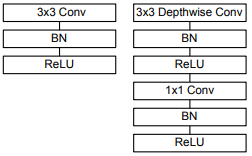

Структура сверточной части сети MobileNet: сверточный блок как слева на рисунке, затем 13 блоков как справа на рисунке.

In [144]:
class DepthSepConv2d(nn.Module):
    """ An implementation of the Depth-wise seperable convolutional layers described in the paper 
        "MobileNets: Efficient Convolutional Neural Networks for Mobile VisionApplications" """
    def __init__(self, chan_in, chan_out, kernel_size,stride):
        super().__init__()
        self.dwconv = DepthwiseConv2d(chan_in, kernel_size=kernel_size,stride=stride)
        self.bnorm1  = nn.BatchNorm2d(chan_in)
        self.pwconv = nn.Conv2d(chan_in, chan_out, kernel_size=1, stride=1)
        self.bnorm2  = nn.BatchNorm2d(chan_out)
    
    def forward(self, x):
        x = nn.functional.relu(self.bnorm1(self.dwconv(x)))
        x = nn.functional.relu(self.bnorm2(self.pwconv(x)))
        return x

class DepthwiseConv2d(nn.Module):
    def __init__(self, chan_in, kernel_size, stride):
        super().__init__()
        self.kernels = [nn.Conv2d(1,1, kernel_size=kernel_size, padding=kernel_size//2, \
                        padding_mode='reflect',stride=stride).to(device) for _ in range(chan_in)]
        
    def forward(self, x):
        channels = [kernel(x[:,chan:chan+1,:,:]) for chan, kernel in enumerate(self.kernels)]
        return torch.cat(channels,1)

class MobileNet(nn.Module):
    """ An implementation of the light weigh image recognition architecture described 
        in the 2017 paper "MobileNets: Efficient Convolutional Neural Networks for 
        Mobile Vision Applications" by Howard et al. """
    def __init__(self, n_classes , alpha=1, rho=1):
        super().__init__()
        self.n_classes = n_classes
        # Initial Ordinary Convolutional Layer
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1, padding_mode='reflect')
        # Intermediate 3x3 Depth-Wise Separable Layers
        self.codw1 = DepthSepConv2d(32,64,kernel_size=3,stride=1)
        self.codw2 = DepthSepConv2d(64,128,kernel_size=3,stride=2)
        self.codw3 = DepthSepConv2d(128,128,kernel_size=3,stride=1)
        self.codw4 = DepthSepConv2d(128,256,kernel_size=3,stride=2)
        self.codw5 = DepthSepConv2d(256,256,kernel_size=3,stride=1)
        self.codw6 = DepthSepConv2d(256,512,kernel_size=3,stride=2)
        # Repeated Constant Resolution 3x3 Depth-Wise Separable Layers
        self.codw7 = DepthSepConv2d(512,512,kernel_size=3,stride=1)
        self.codw8 = DepthSepConv2d(512,512,kernel_size=3,stride=1)
        self.codw9 = DepthSepConv2d(512,512,kernel_size=3,stride=1)
        self.codw10 = DepthSepConv2d(512,512,kernel_size=3,stride=1)
        self.codw11 = DepthSepConv2d(512,512,kernel_size=3,stride=1)
        # 2 Stride 2 3x3 Depth-Wise Separable Layers
        self.codw12 = DepthSepConv2d(512,1024,kernel_size=3,stride=2)
        self.codw13 = DepthSepConv2d(1024,1024,kernel_size=3,stride=1)
        # Global Average Pool and Fully connected output layer
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(1024,n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.codw1(x)
        x = self.codw2(x)
        x = self.codw3(x)
        x = self.codw4(x)
        x = self.codw5(x)
        x = self.codw6(x)
        x = self.codw7(x)
        x = self.codw8(x)
        x = self.codw9(x)
        x = self.codw10(x)
        x = self.codw11(x)
        x = self.codw12(x)
        x = self.codw13(x)
        x = self.avgpool(x)
        x = x.view(-1,1024)
        x = self.fc(x)
        probas = nn.functional.softmax(x, dim=1)
        return x, probas

##Обучение и оценивание

Функции для обучения сети и для валидации

In [18]:
def evaluate_net(net, testloader, criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs, probas = net(images)
            outputs, probas = outputs.to('cpu'), probas.to('cpu')
            # print(torch.max(outputs, dim=1)[0].size())
            # print(labels.size())
            total += labels.size(0)
            loss += float(criterion(probas, labels).detach())
            correct += float(((torch.max(outputs, dim=1)[1] == labels).sum()).detach())
            # print(correct)
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

In [19]:
def optimize_net(net, optimizer, criterion,
                 trainloader, testloader, n_epochs=50,
                 device='cpu', verbose=True, batch_verbose_proportion=0.5, 
                 verbose_data=None, save_path='net.pth'):
    net = net.to(device)
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    if verbose_data is None:
        verbose_data = {
            'train_verbose_steps': [],
            'train_loss': [],
            'test_verbose_steps': [],
            'test_loss': [],
            'test_accuracy': []
        }
    
    for epoch in tqdm(range(n_epochs)):
        net.train()
        running_loss = 0.0
        total_objects = 0
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, probas = net(inputs)
            loss = criterion(probas, labels)
            
            loss.backward()
            optimizer.step()

            running_loss += float(loss.item())
            total_objects += outputs.shape[0]

            if i % n_batches_for_verbose == n_batches_for_verbose - 1:
                epoch_value = epoch + np.around(i / n_batches, 2)
                new_train_loss = running_loss / total_objects
                if verbose:
                    print(
                        '[{:.2f}] loss: {:.3f}'
                        .format(epoch_value, new_train_loss)
                    )
                running_loss = 0
                total_objects = 0
                verbose_data['train_verbose_steps'].append(epoch_value)
                verbose_data['train_loss'].append(new_train_loss * 100)  
       
        with torch.no_grad():
            test_loss, test_accuracy = evaluate_net(net, testloader, criterion, device)
        verbose_data['test_verbose_steps'].append(epoch + 1)
        verbose_data['test_loss'].append(test_loss * 100)
        verbose_data['test_accuracy'].append(test_accuracy * 100)
            
        if verbose:
            print(
                '[{}] test_loss: {:.3f}\n test accuracy: {}'
                .format(epoch + 1, test_loss, test_accuracy)
            )
        print('------------------------------')
    torch.save(net.state_dict(), save_path)
    if verbose:
        print('Finished Training')
    return verbose_data

##Эксперименты

Параметры и метод оптимизации будем для всех архитектур использовать общие

In [20]:
lr = 1e-4
weight_decay = 1e-4
batch_size = 1000
n_epochs = 50

In [21]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

###LeNet

In [26]:
#!g1.1
lenet = LeNet5(n_classes=10)

In [27]:
#!g1.1
criterion_lenet = nn.CrossEntropyLoss()
optimizer_lenet = optim.Adam(lenet.parameters(), lr=lr, weight_decay=weight_decay)

In [28]:
#!g1.1
lenet_data = optimize_net(
    lenet, optimizer_lenet, criterion_lenet,
    train_loader32, test_loader32, 
    n_epochs=n_epochs, device=device, save_path='lenet_logloss.pth'
)

[0.50] loss: 0.035
[1.00] loss: 0.035
[1] test_loss: 0.035
 test accuracy: 0.18766666666666668
------------------------------
[1.50] loss: 0.035
[2.00] loss: 0.035
[2] test_loss: 0.035
 test accuracy: 0.18766666666666668
------------------------------
[2.50] loss: 0.035
[3.00] loss: 0.035
[3] test_loss: 0.035
 test accuracy: 0.18766666666666668
------------------------------
[3.50] loss: 0.035
[4.00] loss: 0.035
[4] test_loss: 0.035
 test accuracy: 0.18766666666666668
------------------------------
[4.50] loss: 0.035
[5.00] loss: 0.034
[5] test_loss: 0.034
 test accuracy: 0.2763333333333333
------------------------------
[5.50] loss: 0.034
[6.00] loss: 0.034
[6] test_loss: 0.034
 test accuracy: 0.31266666666666665
------------------------------
[6.50] loss: 0.033
[7.00] loss: 0.033
[7] test_loss: 0.033
 test accuracy: 0.37366666666666665
------------------------------
[7.50] loss: 0.033
[8.00] loss: 0.032
[8] test_loss: 0.032
 test accuracy: 0.398
------------------------------
[8.50] 

###AlexNet

In [29]:
#!g1.1
alexnet = AlexNet(n_classes=10)

In [30]:
#!g1.1
criterion_alexnet = nn.CrossEntropyLoss()
optimizer_alexnet = optim.Adam(alexnet.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
#!g1.1
alexnet_data = optimize_net(
    alexnet, optimizer_alexnet, criterion_alexnet,
    train_loader, test_loader, 
    n_epochs=n_epochs, device=device, save_path='alexnet_logloss.pth'
)

[0.50] loss: 0.034
[1.00] loss: 0.032
[1] test_loss: 0.032
 test accuracy: 0.43025
------------------------------
[1.50] loss: 0.031
[2.00] loss: 0.029
[2] test_loss: 0.029
 test accuracy: 0.60925
------------------------------
[2.50] loss: 0.029
[3.00] loss: 0.028
[3] test_loss: 0.028
 test accuracy: 0.6910833333333334
------------------------------
[3.50] loss: 0.027
[4.00] loss: 0.027
[4] test_loss: 0.027
 test accuracy: 0.7553333333333333
------------------------------
[4.50] loss: 0.027
[5.00] loss: 0.026
[5] test_loss: 0.026
 test accuracy: 0.8021666666666667
------------------------------
[5.50] loss: 0.026
[6.00] loss: 0.026
[6] test_loss: 0.026
 test accuracy: 0.8183333333333334
------------------------------
[6.50] loss: 0.025
[7.00] loss: 0.025
[7] test_loss: 0.025
 test accuracy: 0.8815833333333334
------------------------------
[7.50] loss: 0.024
[8.00] loss: 0.024
[8] test_loss: 0.025
 test accuracy: 0.8736666666666667
------------------------------
[8.50] loss: 0.024
[9.

###VGG

In [ ]:
import gc
#del variables
gc.collect()

In [41]:
#!g1.2
vgg1 = VGG(make_layers(cfg), n_classes=10)

Access Denied: Spec L2 is not available for your cloud. Please contact your administrator or Support

In [42]:
#!g1.2
criterion_vgg1 = nn.CrossEntropyLoss()
optimizer_vgg1 = optim.Adam(vgg1.parameters(), lr=lr, weight_decay=weight_decay)

Access Denied: Spec L2 is not available for your cloud. Please contact your administrator or Support

In [43]:
#!g1.2
vgg1_data = optimize_net(
    vgg1, optimizer_vgg1, criterion_vgg1,
    train_loader, test_loader, 
    n_epochs=n_epochs, device=device, save_path='vgg1_logloss.pth'
)

Access Denied: Spec L2 is not available for your cloud. Please contact your administrator or Support

In [51]:
#!g1.1
device2 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Access Denied: Spec L2 is not available for your cloud. Please contact your administrator or Support

In [124]:
#!g1.1
vgg = VGG(make_layers(cfg), n_classes=10)
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(vgg.parameters(), lr=lr, weight_decay=weight_decay)

In [125]:
#!g1.1
vgg_data = optimize_net(
    vgg, optimizer_vgg, criterion_vgg,
    train_loader, test_loader, 
    n_epochs=n_epochs, device=device, save_path='vgg_logloss.pth'
)

[0.50] loss: 0.035
[1.00] loss: 0.033
[1] test_loss: 0.032
 test accuracy: 0.40066666666666667
------------------------------
[1.50] loss: 0.031
[2.00] loss: 0.031
[2] test_loss: 0.031
 test accuracy: 0.4920833333333333
------------------------------
[2.50] loss: 0.031
[3.00] loss: 0.031
[3] test_loss: 0.031
 test accuracy: 0.5060833333333333
------------------------------
[3.50] loss: 0.030
[4.00] loss: 0.030
[4] test_loss: 0.031
 test accuracy: 0.5045833333333334
------------------------------
[4.50] loss: 0.030
[5.00] loss: 0.030
[5] test_loss: 0.030
 test accuracy: 0.5565
------------------------------
[5.50] loss: 0.029
[6.00] loss: 0.029
[6] test_loss: 0.028
 test accuracy: 0.6406666666666667
------------------------------
[6.50] loss: 0.028
[7.00] loss: 0.028
[7] test_loss: 0.028
 test accuracy: 0.6765833333333333
------------------------------
[7.50] loss: 0.028
[8.00] loss: 0.028
[8] test_loss: 0.028
 test accuracy: 0.68775
------------------------------
[8.50] loss: 0.028
[9.

###ResNet


In [61]:
#!g1.1
resnet = resnet18(n_classes=10)

In [62]:
#!g1.1
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)

In [63]:
#!g1.1
resnet_data = optimize_net(
    resnet, optimizer_resnet, criterion_resnet,
    train_loader, test_loader, 
    n_epochs=n_epochs, device=device, save_path='resnet_logloss.pth'
)

[0.50] loss: 0.032
[1.00] loss: 0.026
[1] test_loss: 0.025
 test accuracy: 0.88575
------------------------------
[1.50] loss: 0.025
[2.00] loss: 0.024
[2] test_loss: 0.025
 test accuracy: 0.90425
------------------------------
[2.50] loss: 0.024
[3.00] loss: 0.024
[3] test_loss: 0.024
 test accuracy: 0.922
------------------------------
[3.50] loss: 0.024
[4.00] loss: 0.024
[4] test_loss: 0.024
 test accuracy: 0.9265833333333333
------------------------------
[4.50] loss: 0.024
[5.00] loss: 0.024
[5] test_loss: 0.024
 test accuracy: 0.9305833333333333
------------------------------
[5.50] loss: 0.024
[6.00] loss: 0.024
[6] test_loss: 0.024
 test accuracy: 0.9218333333333333
------------------------------
[6.50] loss: 0.024
[7.00] loss: 0.024
[7] test_loss: 0.024
 test accuracy: 0.9400833333333334
------------------------------
[7.50] loss: 0.024
[8.00] loss: 0.024
[8] test_loss: 0.024
 test accuracy: 0.93925
------------------------------
[8.50] loss: 0.023
[9.00] loss: 0.024
[9] test

###Inception


К сожалению, для следующих архитектур на доступной GPU в яндексе не хватило памяти :(\
Ответа от поддержки для доступа к более мощным я не дождался.

In [84]:
#!g2.1
googlenet = GoogLeNet(n_classes=10)

Access Denied: Spec G21 is not available for your cloud. Please contact your administrator or Support

In [85]:
#!g2.1
criterion_googlenet = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet.parameters(), lr=lr, weight_decay=weight_decay)

Access Denied: Spec G21 is not available for your cloud. Please contact your administrator or Support

In [86]:
#!g2.1
googlenet_data = optimize_net(
    googlenet, optimizer_googlenet, criterion_googlenet,
    train_loader, test_loader, 
    n_epochs=n_epochs, device=device, save_path='googlenet_logloss.pth'
)

Access Denied: Spec G21 is not available for your cloud. Please contact your administrator or Support

###DenseNet


In [107]:
#!g1.1
densenet = DenseNet(growth_rate=12, depth=100, reduction=0.5,
                            bottleneck=True, n_classes=10)

In [108]:
#!g1.1
criterion_densenet = nn.CrossEntropyLoss()
optimizer_densenet = optim.Adam(densenet.parameters(), lr=lr, weight_decay=weight_decay)

In [109]:
#!g1.1
densenet_data = optimize_net(
    densenet, optimizer_densenet, criterion_densenet,
    train_loader, test_loader, 
    n_epochs=n_epochs, device=device, save_path='densenet_logloss.pth'
)

RuntimeError: CUDA out of memory. Tried to allocate 1.29 GiB (GPU 0; 31.75 GiB total capacity; 29.77 GiB already allocated; 555.50 MiB free; 29.77 GiB reserved in total by PyTorch)

###MobileNet

In [141]:
#!g1.1
mobilenet = MobileNet(n_classes=10)

In [142]:
#!g1.1
criterion_mobilenet = nn.CrossEntropyLoss()
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=lr, weight_decay=weight_decay)

In [143]:
#!g1.1
mobilenet_data = optimize_net(
    mobilenet, optimizer_mobilenet, criterion_mobilenet,
    train_loader, test_loader, 
    n_epochs=n_epochs, device=device, save_path='mobilenet_logloss.pth'
)

KeyboardInterrupt: 

###Выводы

<Figure size 1440x1080 with 0 Axes>

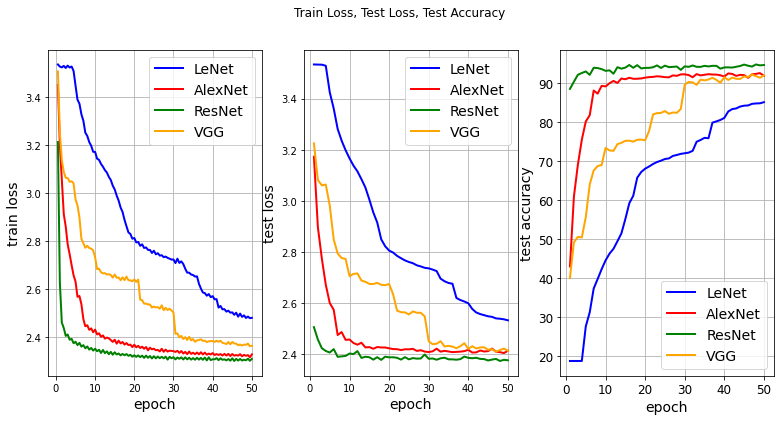

In [135]:
plt.figure(figsize=(20, 15))
fig, ax = plt.subplots(1, 3)
fig.set_figheight(6)
fig.set_figwidth(13)
fig.suptitle('Train Loss, Test Loss, Test Accuracy')

ax[0].plot(lenet_data['train_verbose_steps'],
         lenet_data['train_loss'], 'b', linewidth=2)
ax[0].plot(alexnet_data['train_verbose_steps'],
         alexnet_data['train_loss'], 'r', linewidth=2)
ax[0].plot(resnet_data['train_verbose_steps'],
         resnet_data['train_loss'], 'g', linewidth=2)
ax[0].plot(vgg_data['train_verbose_steps'],
         vgg_data['train_loss'], 'orange', linewidth=2)
ax[1].plot(lenet_data['test_verbose_steps'],
         lenet_data['test_loss'], 'b', linewidth=2)
ax[1].plot(alexnet_data['test_verbose_steps'],
         alexnet_data['test_loss'], 'r', linewidth=2)
ax[1].plot(resnet_data['test_verbose_steps'],
         resnet_data['test_loss'], 'g', linewidth=2)
ax[1].plot(vgg_data['test_verbose_steps'],
         vgg_data['test_loss'], 'orange', linewidth=2)
ax[2].plot(lenet_data['test_verbose_steps'],
         lenet_data['test_accuracy'], 'b', linewidth=2)
ax[2].plot(alexnet_data['test_verbose_steps'],
         alexnet_data['test_accuracy'], 'r', linewidth=2)
ax[2].plot(resnet_data['test_verbose_steps'],
         resnet_data['test_accuracy'], 'g', linewidth=2)
ax[2].plot(vgg_data['test_verbose_steps'],
         vgg_data['test_accuracy'], 'orange', linewidth=2)

ax[0].legend(['LeNet', 'AlexNet', 'ResNet', 'VGG'], fontsize=14)
ax[1].legend(['LeNet', 'AlexNet', 'ResNet', 'VGG'], fontsize=14)
ax[2].legend(['LeNet', 'AlexNet', 'ResNet', 'VGG'], fontsize=14)

ax[0].set_xlabel('epoch', fontsize=14)
ax[0].set_ylabel('train loss', fontsize=14)
ax[1].set_xlabel('epoch', fontsize=14)
ax[1].set_ylabel('test loss', fontsize=14)
ax[2].set_xlabel('epoch', fontsize=14)
ax[2].set_ylabel('test accuracy', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
    
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

Быстрее всех обучается ResNet. Качество здесь также наилучшее.

In [150]:
print(' LeNet:', lenet_data['test_accuracy'][-1], '\n',
      'AlexNet:', alexnet_data['test_accuracy'][-1], '\n',
      'VGG:', vgg_data['test_accuracy'][-1], '\n',
      'ResNet:', resnet_data['test_accuracy'][-1])

 LeNet: 85.175 
 AlexNet: 91.95833333333333 
 VGG: 92.04166666666667 
 ResNet: 94.70833333333334


VGG хоть и обучается медленнее, чем AlexNet, но качество показывает лучше (оно и понятно, параметров гораздо больше). Как можно видеть, итоговое качество на тестовой части растет вместе с ростом параметров. 